<a href="https://colab.research.google.com/github/stefanoiervese/DL_Project/blob/main/Copia_di_DL_aggiornato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

In [88]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.getcwd()
path='/content/drive/MyDrive/mathematics_dataset-v1.0/extrapolate/'
data_list=[]
print(os.listdir(path))
for file in os.listdir(path):

  with open(path+file, "r") as file:
    # Leggi il contenuto del file
    content = file.read()
    data_list=data_list+[x for x in content.split('\n')]



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['arithmetic__add_or_sub_big.txt', 'arithmetic__div_big.txt', 'algebra__polynomial_roots_big.txt', 'arithmetic__add_sub_multiple_longer.txt', 'arithmetic__mul_div_multiple_longer.txt', 'comparison__kth_biggest_more.txt', 'arithmetic__mixed_longer.txt', 'arithmetic__mul_big.txt', 'comparison__closest_more.txt', 'comparison__sort_more.txt', 'numbers__place_value_big.txt', 'measurement__conversion.txt', 'numbers__round_number_big.txt', 'probability__swr_p_level_set_more_samples.txt', 'probability__swr_p_sequence_more_samples.txt']


In [89]:
while '' in data_list:
    data_list.remove('')


In [91]:
import random
import re

#data_list = [x for x in content.split('\n')]
#data_list=data_list[:-1]
len_data=len(data_list)
quest=[]
ans=[]
for i in range(len_data):
  if(i%2==0):
    quest.append(data_list[i])
  else:
    data="# " + data_list[i] + " @"
    ans.append(data)
coppie = list(zip(quest,ans))
random.shuffle(coppie)
quest, ans=zip(*coppie)
l=int(len(quest)/3)
train_q=quest[:2*l]
test_q=quest[2*l:]
train_a=ans[:2*l]
test_a=ans[2*l:]



def crea_vocabolario(frasi):
    vocabolario = set()

    for frase in frasi:
        # Utilizza un'espressione regolare per estrarre parole, numeri e simboli dalla frase
        parole = re.findall(r'\b\w+\b|\d+|[^\w\s]', frase.lower())

        # Aggiungi le parole al vocabolario
        vocabolario.update(parole)


    return ['&','#','@','unknown']+list(vocabolario)

v=crea_vocabolario(data_list)

# Token

In [92]:
class Tokenizer:
    def __init__(self, vocab):
        self.vocab = vocab
        self.word_to_id = {word: idx for idx, word in enumerate(vocab)}

    def tokenize(self, text):
        tokens = re.findall(r'\b\w+\b|\d+|[^\w\s]', text)



        token_id = []
        unknown_tokens = []

        new_tokens = []
        for token in tokens:
          flag=0
          if '.' in token and token != '.':
            token=token=token.split('.')[0]
            flag=1
          if token in self.word_to_id:
            token_id.append(self.word_to_id[token])
          else:
                token_id.append(self.word_to_id['unknown'])
                unknown_tokens.append(token)
          if(flag==1):
            token_id.append(self.word_to_id['.'])


        if unknown_tokens:

          print("Parole sconosciute:", unknown_tokens)

        return token_id



tokenizer = Tokenizer(v)

tokenizer.tokenize('[@ ?ai] ')



Parole sconosciute: ['[', 'ai', ']']


[3, 2, 34517, 3, 3]

# DataLoader

In [93]:
import torch
qt=[]
at=[]
for x in train_q:
  qt.append(torch.tensor(tokenizer.tokenize(x.lower())))
for x in train_a:
  at.append(torch.tensor(tokenizer.tokenize(x.lower())))

qtest=[]
atest=[]
for x in test_q:
  qtest.append(torch.tensor(tokenizer.tokenize(x.lower())))
for x in test_a:
  atest.append(torch.tensor(tokenizer.tokenize(x.lower())))






In [86]:
pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.0/727.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 15.5 MB/s eta 0:00:00


In [94]:

import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_sequence, pad_sequence


class Dataset(Dataset):
    def __init__(self, questions, answers):
        self.questions = questions
        self.answers = answers

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        return self.questions[idx], self.answers[idx]




#voc_size=100
#src_data = torch.randint(1, voc_size, (3264, 6))
#tg_data=torch.randint(1,voc_size,(3264,8))
#fake_dataset=Dataset(src_data,tg_data)
#fake_loader=DataLoader(fake_dataset,batch_size=32,shuffle=True)

max_length1 = max(len(tensor) for tensor in qt)
max_length2 = max(len(tensor) for tensor in at)
max_length=max(max_length1,max_length2)
print(max_length)
qtp = pad_sequence([torch.cat([tensor, torch.zeros(max_length - len(tensor),dtype=torch.int)]) for tensor in qt], batch_first=True)
atp = pad_sequence([torch.cat([tensor, torch.zeros(max_length - len(tensor),dtype=torch.int)]) for tensor in at], batch_first=True)


max_length1 = max(len(tensor) for tensor in qtest)
max_length2 = max(len(tensor) for tensor in atest)
max_length=max(max_length1,max_length2)
qtestp = pad_sequence([torch.cat([tensor, torch.zeros(max_length - len(tensor),dtype=torch.int)]) for tensor in qtest], batch_first=True)
atestp = pad_sequence([torch.cat([tensor, torch.zeros(max_length - len(tensor),dtype=torch.int)]) for tensor in atest], batch_first=True)


batch_size = 64

train_dataset = Dataset(qtp,atp)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
'''
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=lambda batch: (
    pad_sequence([item[0] for item in batch], batch_first=True),
    pad_sequence([item[1] for item in batch], batch_first=True)
))'''
test_dataset = Dataset(qtestp,atestp)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)


75


In [95]:
q,a=next(iter(train_loader))
q.shape

torch.Size([64, 75])

In [96]:
def paper_accuracy(predicted_answers, correct_answers):
  num_correct_answers = 0
  end_of_line=2

  for i in range(len(predicted_answers)):

    # Preparing predicted answer
    single_predicted_answer = torch.argmax(predicted_answers[i], 1).tolist()  # vector of shape (answer_max_length) (concatenates the max value for each row)


    single_predicted_answer = single_predicted_answer[1:single_predicted_answer.index(2)]  # removing start and end of line char and additional characters

    # Preparing correct answer
    single_correct_answer = correct_answers[i].tolist()
    single_correct_answer = single_correct_answer[1:single_correct_answer.index(2)]  # removing start of line, end of line and following characters

    # If the predicted answer and the correct one have the same exact characters, the predicted answer is correct
    #print("Predicted")
    #print(single_predicted_answer)
    #print('Correct')
    #print(single_correct_answer)

    if (single_predicted_answer == single_correct_answer):
      num_correct_answers += 1

  return num_correct_answers/len(predicted_answers)

# Transformer

In [97]:

import torch
import torch.nn as nn
import math
import pytorch_lightning as pl
import torch.optim as optim
import torch.nn.functional as F

class MultiHeadAttention(pl.LightningModule):
    def __init__(self, emb_dim, num_heads,dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert emb_dim % num_heads == 0, "emb_dim must be divisible by num_heads"

        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = self.emb_dim // num_heads

        # Inizializzazione dei moduli lineari per proiettare Q, K, V e l'output.
        self.W_q = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_k = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_v = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_o = nn.Linear(self.emb_dim, self.emb_dim)


    def forward(self, q,k,v):
        q = self.split_heads(self.W_q(q))  #64,2,22,2
        k = self.split_heads(self.W_k(k))  #64,2,2,22
        v = self.split_heads(self.W_v(v))


        att = self.att_score(q, k, v)  #62,2,22,22
        out = self.W_o(self.combine_heads(att))

        return out

    def att_score(self, q, k, v):
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        attn_scores=self.apply_mask(attn_scores)




        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, v)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, head_dim = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.emb_dim)

    def apply_mask(self,tensor):
      for i in range(tensor.size(0)):
        for j in range(tensor.size(1)):
          matrix = tensor[i, j]

          mask = torch.triu(torch.ones(matrix.size(0), matrix.size(1)), diagonal=0,).t().to('cuda:0')

          matrix = matrix * mask+ (-1e9) * (1 - mask)
          tensor[i, j] = matrix
          return tensor







class EncoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, feedforward_dim=32, dropout=0.1):
        super(EncoderLayer, self).__init__()

        self.multihead_attention = MultiHeadAttention(emb_dim, num_heads)

        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim)
        )

        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        att = self.multihead_attention(x,x,x)

        add_nor = self.layer_norm1(x + self.dropout(att))
        ff_out = self.feedforward(add_nor)
        out = self.layer_norm2(add_nor + self.dropout(ff_out))


        return out





class Encoder(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, num_layers=6, feedforward_dim=32, dropout=0.1):
        super(Encoder, self).__init__()

        self.layers = nn.ModuleList([
            EncoderLayer(emb_dim, num_heads, feedforward_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class DecoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, feedforward_dim=32, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # Self-Attention Layer (Auto-Attention)
        self.self_attention = MultiHeadAttention(emb_dim, num_heads)

        # Cross-Attention Layer (Attenzione incrociata con l'encoder)
        self.cross_attention = MultiHeadAttention(emb_dim, num_heads)

        # Feedforward Neural Network Layer
        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim)
        )

        # Layer Normalization
        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.layer_norm3 = nn.LayerNorm(emb_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output):

        attn_output = self.self_attention(x, x, x)
        out1 = self.layer_norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attention(out1, encoder_output, encoder_output)
        out2 = self.layer_norm2(out1 + self.dropout(attn_output))
        ff_output = self.feedforward(x)
        out3 = self.layer_norm3(out2 + self.dropout(ff_output))
        return out3

class Decoder(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, num_layers=6, feedforward_dim=32, dropout=0.1):
        super(Decoder, self).__init__()


        self.layers = nn.ModuleList([
            DecoderLayer(emb_dim, num_heads, feedforward_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, encoder_output):
        for layer in self.layers:
            x = layer(x, encoder_output)
        return x

import pytorch_lightning as pl
import torch
import torch.nn as nn

class Transformer(pl.LightningModule):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=4, num_heads=2, num_layers=6, d_ff=256, dropout=0.1):
        super(Transformer, self).__init__()
        self.d_model=d_model

        self.num_heads=num_heads
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)

        self.transformer_encoder = Encoder(self.d_model,self.num_heads

        )
        self.transformer_decoder =Decoder(self.d_model,self.num_heads
        )

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)


    def forward(self, batch):

        src,tgt = batch
        max_seq_length=src.shape[1]

        src_embedded = self.dropout(self.src_embedding(src))+self.positional_encoding(max_seq_length,self.d_model).to('cuda:0')
        tgt_embedded = self.dropout(self.tgt_embedding(tgt))+self.positional_encoding(max_seq_length,self.d_model).to('cuda:0')




        enc_output = self.transformer_encoder(src_embedded)
        dec_output = self.transformer_decoder(tgt_embedded, enc_output)

        output = self.fc(dec_output)

        return output


    def training_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(batch)
        loss = nn.CrossEntropyLoss(ignore_index=0)(output.view(-1, output.size(-1)), tgt.view(-1))
        losses.append(loss.cpu().detach().numpy())
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(src, tgt)

        loss = nn.CrossEntropyLoss(ignore_index=0)(output.view(-1, output.size(-1)), tgt.view(-1))
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def test_step(self, batch, batch_idx):
        batch_q, batch_a = batch

      # Computing prediction and accuracy
        pred = self(batch)  # shape (batch_size, answer_max_length, dict_size)
        accuracy = paper_accuracy(pred, batch_a)  # accuracy for the current batch as defined in the "mathematics dataset" paper

        #print_correct(self.dictionary, batch, pred)

        #print(accuracy)  # at the end of every epoch it is logged the average of the accuracies of each batch
        acc.append(accuracy)

        return accuracy




    def positional_encoding(self, max_seq_length, d_model):

        positional_encoding = torch.zeros(max_seq_length, d_model)
        pos = torch.arange(0, max_seq_length, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        positional_encoding[:, 0::2] = torch.sin(pos * div_term)
        positional_encoding[:, 1::2] = torch.cos(pos * div_term)
        return positional_encoding




acc=[]
losses=[]
voc_len=len(v)
t=Transformer(voc_len,voc_len)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t.to(device)
print(device)
# Addestra il modello

trainer = pl.Trainer(max_epochs=3)  # Modifica il numero di epoche come desiderato
trainer.fit(t, train_loader)


#model_path='/content/drive/MyDrive/mathematics_dataset-v1.0/model'


#torch.save(t.state_dict(), model_path)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


cpu


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type      | Params
--------------------------------------------------
0 | src_embedding       | Embedding | 743 K 
1 | tgt_embedding       | Embedding | 743 K 
2 | transformer_encoder | Encoder   | 2.3 K 
3 | transformer_decoder | Decoder   | 2.9 K 
4 | fc                  | Linear    | 929 K 
5 | dropout             | Dropout   | 0     
--------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.683     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

RuntimeError: ignored

In [32]:
sum(acc)/len(acc)

0.8277239469787339

In [24]:
model_path='/content/drive/MyDrive/modellino.pth'
#torch.save(t.state_dict(), model_path)
trainer.test(t,test_loader)



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

[{}]

In [85]:
trainer.test(t,test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

ValueError: ignored

In [82]:
sum(acc)/len(acc)

0.9502231500143967

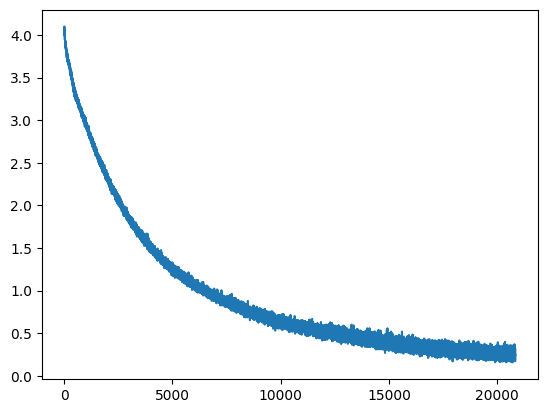

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

In [ ]:
torch.save(t.state_dict(), 'trainato')

In [23]:
t.load_state_dict(torch.load('/content/drive/MyDrive/modellino.pth'))

<All keys matched successfully>

# TP-Transformer

In [86]:

class TPMultiHeadAttention(pl.LightningModule):
    def __init__(self, emb_dim, num_heads,dropout=0.1):
        super(TPMultiHeadAttention, self).__init__()
        assert emb_dim % num_heads == 0, "emb_dim must be divisible by num_heads"

        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = self.emb_dim // num_heads

        # Inizializzazione dei moduli lineari per proiettare Q, K, V e l'output.
        self.W_q = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_k = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_v = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_r = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_o = nn.Linear(self.emb_dim, self.emb_dim)


    def forward(self, q,k,v,r):
        q = self.split_heads(self.W_q(q))  #64,2,22,2
        k = self.split_heads(self.W_k(k))  #64,2,2,22
        v = self.split_heads(self.W_v(v))
        r = self.split_heads(self.W_r(r))


        att = self.att_score(q, k, v)  #62,2,22,22
        #filler = torch.tensordot(att, r, dims=0)
        #diagonal = torch.diagonal(filler)
        #print(att.shape,filler.shape,diagonal.shape)


        out = self.W_o(self.combine_heads(att*r))


        return out

    def att_score(self, q, k, v):
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        attn_scores=self.apply_mask(attn_scores)




        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, v)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, head_dim = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.emb_dim)

    def apply_mask(self,tensor):
      for i in range(tensor.size(0)):
        for j in range(tensor.size(1)):
          matrix = tensor[i, j]

          mask = torch.triu(torch.ones(matrix.size(0), matrix.size(1)), diagonal=0,).t().to('cuda:0')

          matrix = matrix * mask+ (-1e9) * (1 - mask)
          tensor[i, j] = matrix
          return tensor







class TPEncoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, feedforward_dim=32, dropout=0.1):
        super(TPEncoderLayer, self).__init__()

        self.multihead_attention = MultiHeadAttention(emb_dim, num_heads)

        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim)
        )

        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        att = self.multihead_attention(x,x,x,x)

        add_nor = self.layer_norm1(x + self.dropout(att))
        ff_out = self.feedforward(add_nor)
        out = self.layer_norm2(add_nor + self.dropout(ff_out))


        return out





class TPEncoder(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, num_layers=6, feedforward_dim=32, dropout=0.1):
        super(TPEncoder, self).__init__()

        self.layers = nn.ModuleList([
            TPEncoderLayer(emb_dim, num_heads, feedforward_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class TPDecoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, feedforward_dim=32, dropout=0.1):
        super(TPDecoderLayer, self).__init__()

        # Self-Attention Layer (Auto-Attention)
        self.self_attention = MultiHeadAttention(emb_dim, num_heads)

        # Cross-Attention Layer (Attenzione incrociata con l'encoder)
        self.cross_attention = MultiHeadAttention(emb_dim, num_heads)

        # Feedforward Neural Network Layer
        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim)
        )

        # Layer Normalization
        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.layer_norm3 = nn.LayerNorm(emb_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output):

        attn_output = self.self_attention(x, x, x,x)
        out1 = self.layer_norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attention(out1, encoder_output,encoder_output, encoder_output)
        out2 = self.layer_norm2(out1 + self.dropout(attn_output))
        ff_output = self.feedforward(x)
        out3 = self.layer_norm3(out2 + self.dropout(ff_output))
        return out3

class TPDecoder(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, num_layers=6, feedforward_dim=32, dropout=0.1):
        super(TPDecoder, self).__init__()


        self.layers = nn.ModuleList([
            TPDecoderLayer(emb_dim, num_heads, feedforward_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, encoder_output):
        for layer in self.layers:
            x = layer(x, encoder_output)
        return x



class TPTransformer(pl.LightningModule):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=4, num_heads=2, num_layers=6, d_ff=256, dropout=0.1):
        super(TPTransformer, self).__init__()
        self.d_model=d_model

        self.num_heads=num_heads
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)

        self.transformer_encoder = TPEncoder(self.d_model,self.num_heads

        )
        self.transformer_decoder =TPDecoder(self.d_model,self.num_heads
        )

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)


    def forward(self, batch):

        src,tgt = batch
        max_seq_length=src.shape[1]

        src_embedded = self.dropout(self.src_embedding(src))+self.positional_encoding(max_seq_length,self.d_model).to('cuda:0')
        tgt_embedded = self.dropout(self.tgt_embedding(tgt))+self.positional_encoding(max_seq_length,self.d_model).to('cuda:0')




        enc_output = self.transformer_encoder(src_embedded)
        dec_output = self.transformer_decoder(tgt_embedded, enc_output)

        output = self.fc(dec_output)

        return output


    def training_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(batch)
        loss = nn.CrossEntropyLoss(ignore_index=0)(output.view(-1, output.size(-1)), tgt.view(-1))
        losses.append(loss.cpu().detach().numpy())
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(src, tgt)

        loss = nn.CrossEntropyLoss(ignore_index=0)(output.view(-1, output.size(-1)), tgt.view(-1))
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def test_step(self, batch, batch_idx):
        batch_q, batch_a = batch

      # Computing prediction and accuracy
        pred = self(batch)  # shape (batch_size, answer_max_length, dict_size)
        accuracy = paper_accuracy(pred, batch_a)  # accuracy for the current batch as defined in the "mathematics dataset" paper

        #print_correct(self.dictionary, batch, pred)

        #print(accuracy)  # at the end of every epoch it is logged the average of the accuracies of each batch
        acc.append(accuracy)

        return accuracy




    def positional_encoding(self, max_seq_length, d_model):

        positional_encoding = torch.zeros(max_seq_length, d_model)
        pos = torch.arange(0, max_seq_length, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        positional_encoding[:, 0::2] = torch.sin(pos * div_term)
        positional_encoding[:, 1::2] = torch.cos(pos * div_term)
        return positional_encoding




acc=[]
losses=[]
voc_len=len(v)
t=Transformer(voc_len,voc_len)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t.to(device)
print(device)
# Addestra il modello

trainer = pl.Trainer(max_epochs=3)  # Modifica il numero di epoche come desiderato
trainer.fit(t, train_loader)


#model_path='/content/drive/MyDrive/mathematics_dataset-v1.0/model'


#torch.save(t.state_dict(), model_path)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type      | Params
--------------------------------------------------
0 | src_embedding       | Embedding | 284   
1 | tgt_embedding       | Embedding | 284   
2 | transformer_encoder | Encoder   | 2.4 K 
3 | transformer_decoder | Decoder   | 3.1 K 
4 | fc                  | Linear    | 355   
5 | dropout             | Dropout   | 0     
--------------------------------------------------
6.5 K     Trainable params
0         Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB

cuda


Training: 0it [00:00, ?it/s]